In [13]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install ta-lib

import talib
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import pandas as pd

# Downloading historical data for S&P 500
ticker = "SPY"
data = yf.download(ticker, start="2010-01-01", end="2023-01-01", interval="1d")

# Feature Engineering: Adding technical indicators
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['RSI'] = compute_rsi(data['Close'])

# MACD
data['MACD'], data['MACD_signal'], data['MACD_hist'] = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Bollinger Bands
data['upper_band'], data['middle_band'], data['lower_band'] = talib.BBANDS(data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Stochastic Oscillator
data['slowk'], data['slowd'] = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

# Lag Features
data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)

# Drop rows with NaN values created by the indicators
data.dropna(inplace=True)

# Scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Splitting into train and test
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Reshape data for LSTM [samples, timesteps, features]
train_data_lstm = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))
test_data_lstm = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))


--2024-08-21 15:44:37--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-08-21 15:44:37--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-08-21 15:44:38--  http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Resolvi

[*********************100%%**********************]  1 of 1 completed
<ipython-input-3-3ec88ef22d39>:22: RuntimeWarning: invalid value encountered in divide
  rs = avg_gain / avg_loss


In [14]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_data[:, :-1], train_data[:, -1])
rf_predictions = rf_model.predict(test_data[:, :-1])

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(train_data[:, :-1], train_data[:, -1])
xgb_predictions = xgb_model.predict(test_data[:, :-1])

# LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(1, train_data.shape[1])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_data_lstm, train_data[:, -1], batch_size=1, epochs=1)
lstm_predictions = lstm_model.predict(test_data_lstm)

# Ensemble Predictions with weighted average
weights = {'rf': 0.4, 'xgb': 0.4, 'lstm': 0.2}
ensemble_predictions = (weights['rf'] * rf_predictions +
                        weights['xgb'] * xgb_predictions +
                        weights['lstm'] * lstm_predictions.flatten())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2458/2458 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0032
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [15]:
initial_investment = 10000  # Starting with $10,000
portfolio_value = initial_investment
holdings = 0  # No initial holdings
cash = initial_investment
stop_loss = 0.05  # 5% stop loss
take_profit = 0.1  # 10% take profit

# Simulate trades with stop-loss and take-profit
purchase_price = 0
for i in range(1, len(ensemble_predictions)):
    if ensemble_predictions[i] > test_data[i-1, -1]:  # Buy signal
        if cash > 0:
            purchase_price = test_data[i, -1]
            holdings = cash / purchase_price
            cash = 0
    elif ensemble_predictions[i] < test_data[i-1, -1]:  # Sell signal
        if holdings > 0:
            selling_price = test_data[i, -1]
            if (selling_price - purchase_price) / purchase_price >= take_profit or \
               (purchase_price - selling_price) / purchase_price >= stop_loss:
                cash = holdings * selling_price
                holdings = 0

    portfolio_value = cash + holdings * test_data[i, -1]

# Final portfolio value
print(f"Final Portfolio Value with Risk Management: ${portfolio_value:.2f}")


Final Portfolio Value with Risk Management: $13511.56


In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming daily returns based on predictions
returns = np.diff(test_data[:, -1]) / test_data[:-1, -1]  # Real returns
predicted_returns = np.diff(ensemble_predictions) / test_data[:-1, -1]  # Predicted returns

# Excess returns
risk_free_rate = 0
excess_returns = predicted_returns - risk_free_rate

# Sharpe Ratio
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
print(f"Sharpe Ratio: {sharpe_ratio}")

# Confusion Matrix
actual_signals = np.where(np.diff(test_data[:, -1]) > 0, 1, -1)  # 1 for buy, -1 for sell
predicted_signals = np.where(np.diff(ensemble_predictions) > 0, 1, -1)
conf_matrix = confusion_matrix(actual_signals, predicted_signals, labels=[1, -1])
print(f"Confusion Matrix:\n{conf_matrix}")


Sharpe Ratio: 0.04584320994147608
Confusion Matrix:
[[245  73]
 [114 182]]


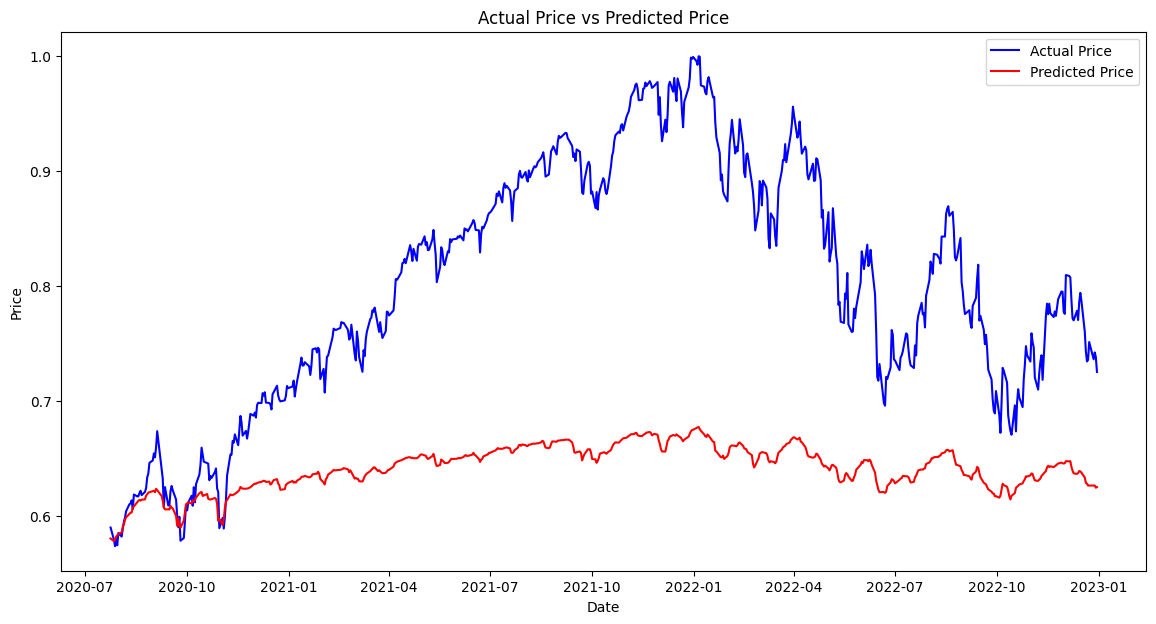

In [17]:
import matplotlib.pyplot as plt

# Plotting the actual price and predicted price
plt.figure(figsize=(14, 7))
plt.plot(data.index[train_size:], test_data[:, -1], color='blue', label='Actual Price')
plt.plot(data.index[train_size:], ensemble_predictions, color='red', label='Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
